# A Comparison of the Monte Carlo Method: Quantum vs. Classical Computers
This notebook demonstrates the application of the Monte Carlo method for (biased) coin toss games, using both quantum and classical computers. However, due to the current lack of perfect quantum machines, we utilize the Qiskit Aer simulator to simulate the behavior of a quantum computer.

This notebook compares the performance of a method using the Quantum Amplitude Estimation (QAE for short) algorithm, which is often described as a quantum version of the Monte Carlo method, and the usual Monte Carlo method, highlighting the potential advantages offered by quantum computing for tackling Monte Carlo simulations.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import WeightedAdder, IntegerComparator
from qiskit import Aer, transpile
from qiskit.circuit.library import HGate, RYGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution

from qiskit.circuit.library import GroverOperator, PhaseEstimation
from qiskit.algorithms import EstimationProblem
from qiskit.algorithms import AmplitudeEstimation
from qiskit.algorithms import IterativeAmplitudeEstimation
# from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation
# from qiskit.algorithms import FasterAmplitudeEstimation
from qiskit.primitives import Sampler
from qiskit.algorithms import AmplitudeEstimation

import numpy as np
from scipy.special import comb

In [2]:
backend = AerSimulator()

Number of ancillas: 3
Number of sum qubits: 3
Number of qubits: 13


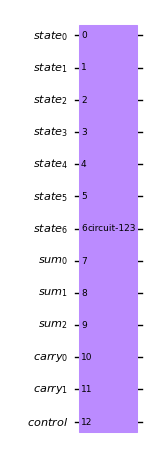

In [3]:
n_state_qubits = 7

qc_wadder = WeightedAdder(n_state_qubits, name='     $\sum_jq_j$     ')
n_ancillas = qc_wadder.num_ancillas
n_sum_qubits = qc_wadder.num_sum_qubits
n_qubits = qc_wadder.num_qubits
print(f'Number of ancillas: {n_ancillas}')
print(f'Number of sum qubits: {n_sum_qubits}')
print(f'Number of qubits: {n_qubits}')
qc_wadder.decompose(reps=0).draw('mpl', scale=0.5)

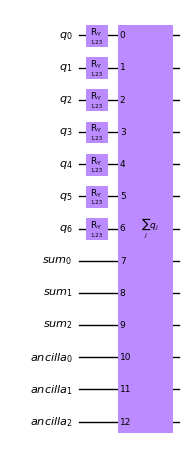

In [4]:
p = 1 / 3
theta = 2 * np.arcsin(np.sqrt(p))

qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qc = QuantumCircuit(qr_state, qr_sum, qr_a)
for i in range(n_state_qubits):
    qc.ry(theta, i)

qc.append(qc_wadder.to_gate(), qargs=range(n_qubits))

U = qc.to_gate()
U.name = '    $U$    '
qc.draw('mpl', scale=0.5)

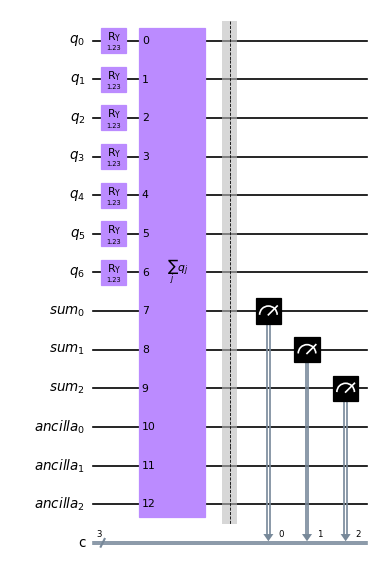

In [5]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qc = QuantumCircuit(qr_state, qr_sum, qr_a)
qc.append(U, qargs=range(n_qubits))

qc.barrier()
cr = ClassicalRegister(n_sum_qubits, 'c')
qc.add_register(cr)
qc.measure(range(n_state_qubits, n_state_qubits + n_sum_qubits), cr)
qc.decompose().draw('mpl', scale=0.6)

{'011': 2485, '001': 2037, '010': 3158, '100': 1304, '000': 562, '101': 368, '110': 80, '111': 6}
CPU times: total: 0 ns
Wall time: 96.8 ms


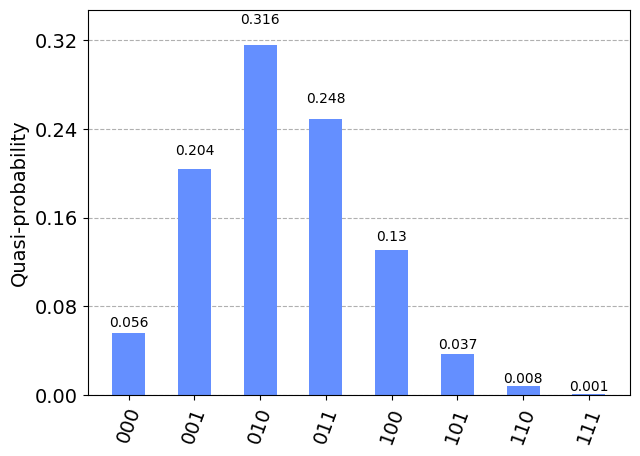

In [6]:
%%time
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

## Upper Probability Estimates

Number of ancillas: 2


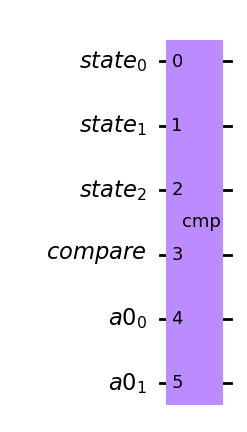

In [7]:
value = 6
qc = IntegerComparator(n_sum_qubits, value=value)
n_anccmp = qc.num_ancillas
print(f'Number of ancillas: {n_anccmp}')
U_cmp = qc.to_gate()
qc.draw('mpl')

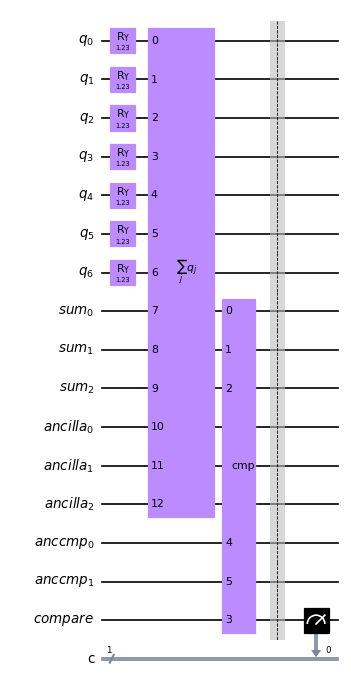

In [8]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_acmp = QuantumRegister(n_anccmp, 'anccmp')
qr_cmp = QuantumRegister(1, 'compare')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_acmp, qr_cmp)

qc.append(U, qargs=range(n_qubits))
qargs = list(range(n_state_qubits, n_state_qubits + n_sum_qubits)) \
        + [n_state_qubits + n_sum_qubits + n_ancillas + n_anccmp] \
        + list(range(n_state_qubits + n_sum_qubits + n_ancillas, 
            n_state_qubits + n_sum_qubits + n_ancillas + n_anccmp))
qc.append(U_cmp, qargs=qargs)

U_upper = qc.to_gate()
U_upper.name = '   $U_{upper\,pr}$   '

qc.barrier()
cr = ClassicalRegister(1, 'c')
qc.add_register(cr)
qc.measure(qc.num_qubits - 1, cr)
qc.decompose().draw('mpl', scale=0.6)

{'0': 99324, '1': 676}
CPU times: total: 594 ms
Wall time: 280 ms


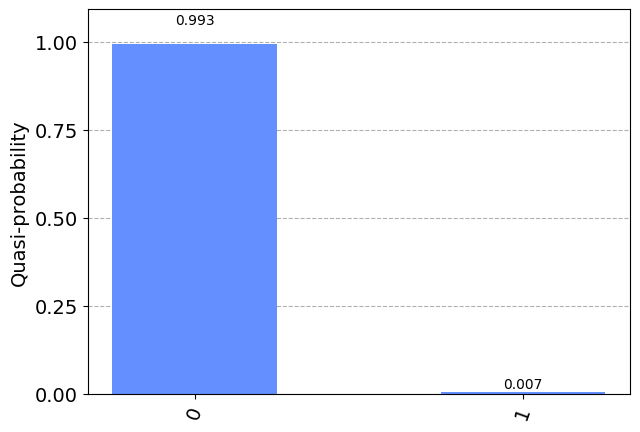

In [9]:
%%time
n_shots = 100000
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=n_shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

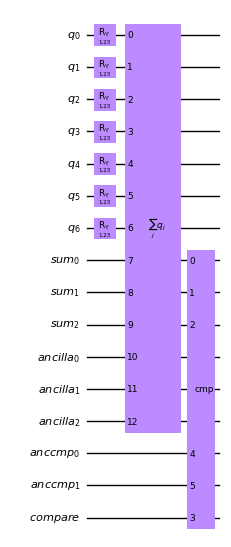

In [10]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_acmp = QuantumRegister(n_anccmp, 'anccmp')
qr_cmp = QuantumRegister(1, 'compare')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_acmp, qr_cmp)

qc.append(U_upper, qargs=range(qc.num_qubits))

qc.decompose(reps=2).draw('mpl', scale=0.5)

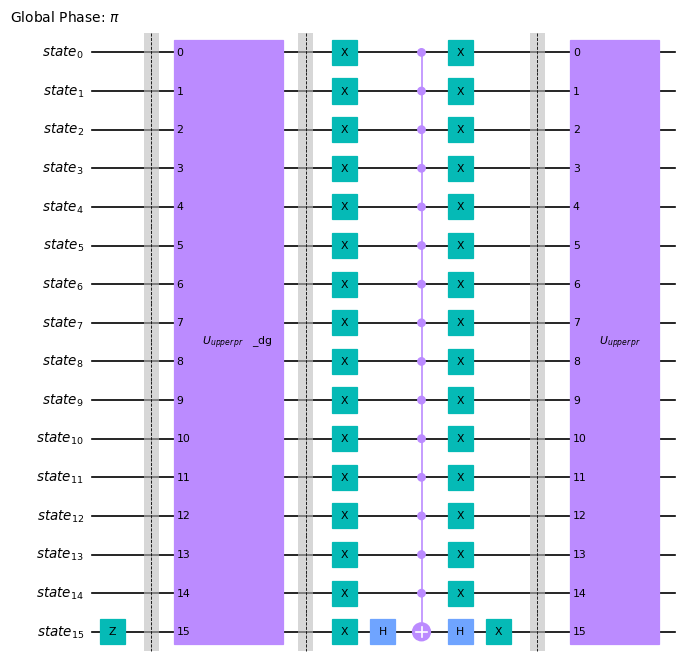

In [11]:
oracle = QuantumCircuit(qc.num_qubits)
oracle.z(qc.num_qubits - 1)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=True)
Q.decompose().draw('mpl', scale=0.6)

In [12]:
problem = EstimationProblem(
    state_preparation=qc,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[qc.num_qubits - 1],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

sampler = Sampler()

In [13]:
%%time
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

CPU times: total: 46.9 ms
Wall time: 412 ms


In [14]:
print(f'Estimate (Iterative-QAE): {iae_result.estimation}')
print(f'Estimate (Sampling): {counts["1"] / n_shots} ({n_shots} samples)')
theoretical_probs = np.array([comb(n_state_qubits, j) * p ** j * (1 - p) ** (n_state_qubits - j) 
                     for j in range(n_state_qubits + 1)])
print(f'Theoretical: {np.sum(theoretical_probs[value:])}')

Estimate (Iterative-QAE): 0.0068587105624143
Estimate (Sampling): 0.00676 (100000 samples)
Theoretical: 0.006858710562414264


## Expectation Value Estimates

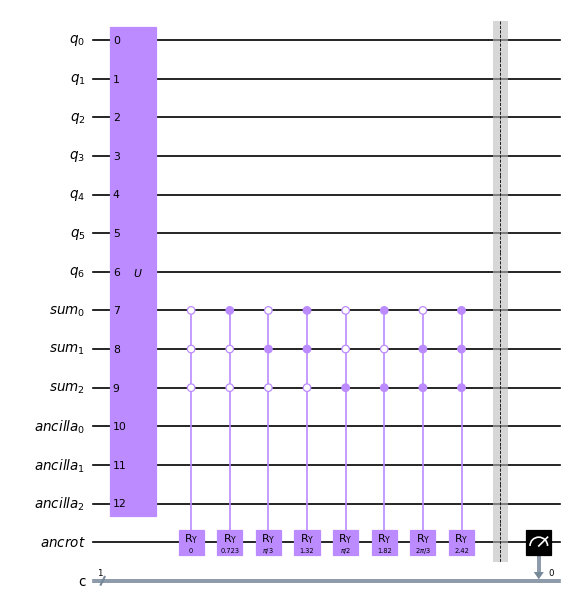

In [15]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_arot = QuantumRegister(1, 'ancrot')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_arot)
qc.append(U, qargs=range(n_qubits))

denominator = 2 ** n_sum_qubits
qargs_rot = list(range(n_state_qubits, n_state_qubits + n_sum_qubits)) + [qc.num_qubits - 1]
for i in range(2 ** n_sum_qubits):
    _theta = 2 * np.arcsin(np.sqrt(i / denominator))
    _RGate = RYGate(_theta).control(n_sum_qubits, ctrl_state=i)
    qc.append(_RGate, qargs=qargs_rot)

U_mc = qc.to_gate()
U_mc.name = 'MC gate'

qc.barrier()
cr = ClassicalRegister(1, 'c')
qc.add_register(cr)
qc.measure(qc.num_qubits - 1, cr)
qc.decompose(reps=0).draw('mpl', scale=0.6)

{'0': 70963, '1': 29037}
CPU times: total: 109 ms
Wall time: 427 ms


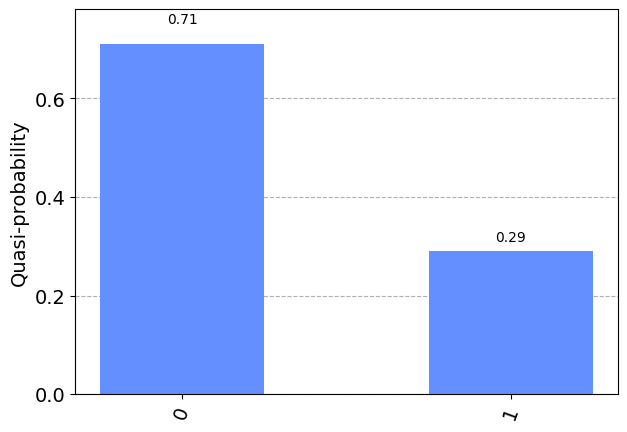

In [16]:
%%time
n_shots = 100000
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=n_shots)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

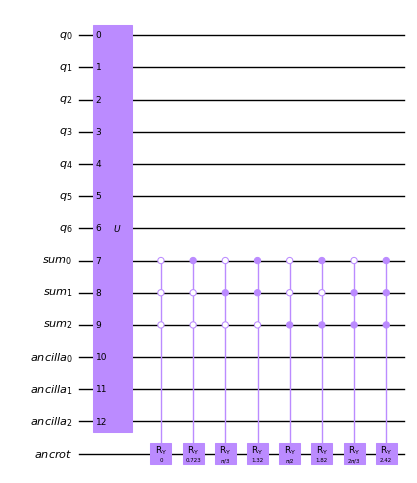

In [17]:
qr_state = QuantumRegister(n_state_qubits, 'q')
qr_sum = QuantumRegister(n_sum_qubits, 'sum')
qr_a = QuantumRegister(n_ancillas, 'ancilla')
qr_arot = QuantumRegister(1, 'ancrot')
qc = QuantumCircuit(qr_state, qr_sum, qr_a, qr_arot)
qc.append(U_mc, qargs=range(qc.num_qubits))

qc.decompose(reps=1).draw('mpl', scale=0.5)

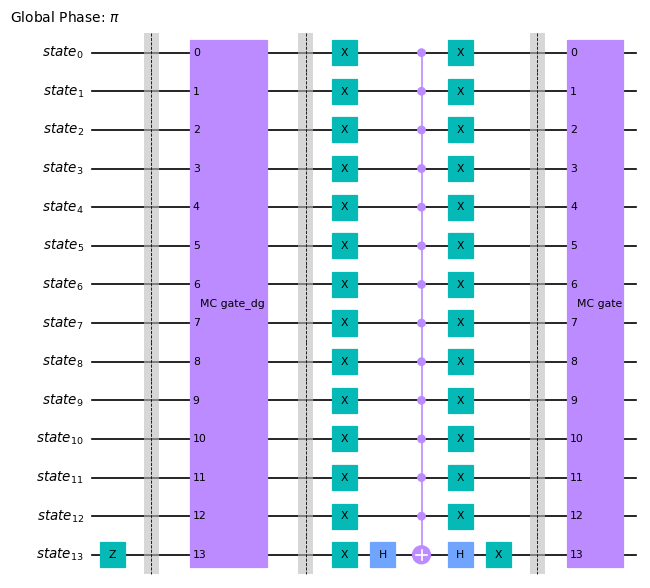

In [18]:
oracle = QuantumCircuit(qc.num_qubits)
oracle.z(qc.num_qubits - 1)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=True)
Q.decompose().draw('mpl', scale=0.6)

In [19]:
problem = EstimationProblem(
    state_preparation=qc,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[qc.num_qubits - 1],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

sampler = Sampler()

In [20]:
%%time
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

CPU times: total: 62.5 ms
Wall time: 443 ms


In [21]:
print(f'Estimate (Iterative-QAE): {denominator * iae_result.estimation}')
print(f'Estimate (Sampling): {denominator * counts["1"] / n_shots} ({n_shots} samples)')
print(f'Theoretical: {np.array(range(n_state_qubits + 1)) @ theoretical_probs}')

Estimate (Iterative-QAE): 2.333333333333336
Estimate (Sampling): 2.32296 (100000 samples)
Theoretical: 2.3333333333333344
